In [7]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from functions import *

## Data Generation

$D_{x}$, $D_{y}$ are the dimensions of the grid the latent variables are placed on. There are then $N$ total coordinates. Index and coordinate grids are then generated.

In [8]:
### Inference grid defining {ui}i=1,Dx*Dy
Dx = 16
Dy = 16
N = Dx * Dy     # Total number of coordinates
points = [(x, y) for y in np.arange(Dx) for x in np.arange(Dy)]                # Indexes for the inference grid
coords = [(x, y) for y in np.linspace(0,1,Dy) for x in np.linspace(0,1,Dx)]    # Coordinates for the inference grid
xi, yi = np.array([c[0] for c in points]), np.array([c[1] for c in points])    # Get x, y index lists
x, y = np.array([c[0] for c in coords]), np.array([c[1] for c in coords])      # Get x, y coordinate lists

In [9]:
### Data grid defining {vi}i=1,N/subsample_factor - subsampled from inference grid
subsample_factor = 4
idx = subsample(N, subsample_factor)
M = len(idx)                                                                   # Total number of data points

In [10]:
### Generate K, the covariance of the Gaussian process, and sample from N(0,K) using a stable Cholesky decomposition
def priorSamples(l):
	K = GaussianKernel(coords, l)
	z = np.random.randn(N, )
	Kc = np.linalg.cholesky(K + 1e-6 * np.eye(N))
	u = Kc @ z
	return u, K

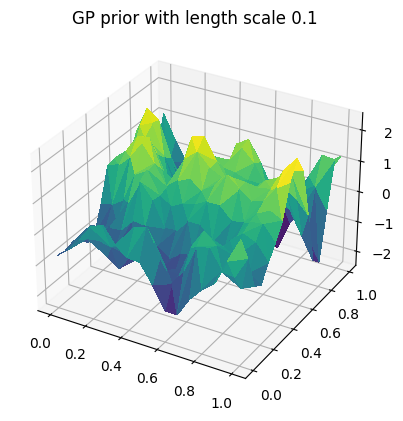

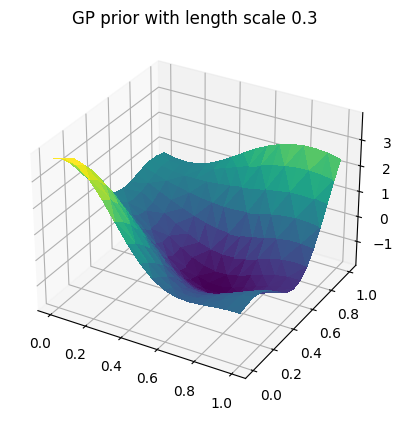

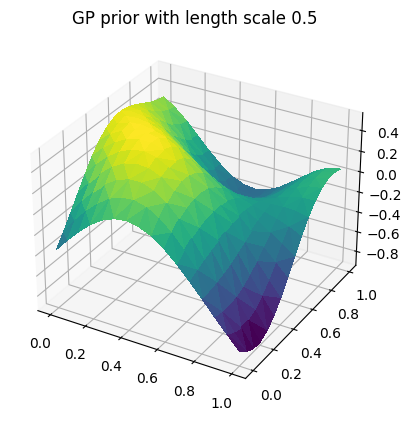

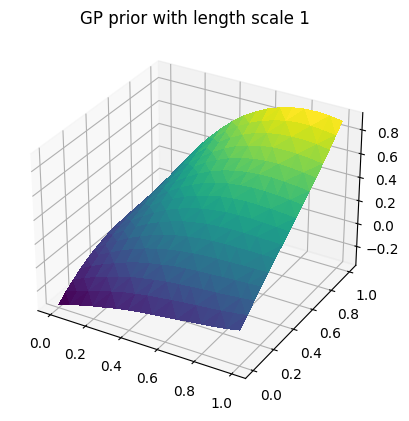

In [11]:
### Part (a)
length_scales = [0.1, 0.3, 0.5, 1]
for l in length_scales:
	u, _ = priorSamples(l)
	plot_3D(u, x, y, title="GP prior with length scale "+str(l))

In [12]:
# generate samples with length scale 0.3
u, K = priorSamples(0.3)
Kc = np.linalg.cholesky(K + 1e-6 * np.eye(N))

# Observation model: v = G(u) + e,   e~N(0,I)
G = get_G(N, idx)
v = G @ u + np.random.randn(M)

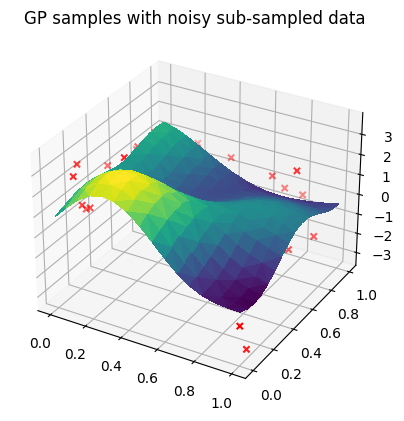

In [13]:
plot_result(u, v, x, y, x[idx], y[idx], title="GP samples with noisy sub-sampled data")

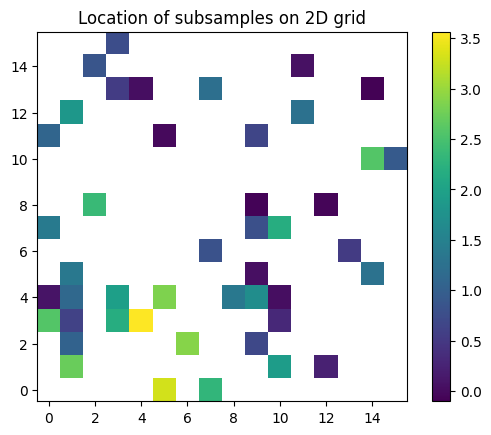

In [14]:
plot_2D(v, xi[idx], yi[idx], title="Location of subsamples on 2D grid")

In [41]:
###--- MCMC ---####

### Set MCMC parameters
n = 10000
beta = 0.2

### Set the likelihood and target, for sampling p(u|v)
log_target = log_continuous_target
log_likelihood = log_continuous_likelihood

### Sample from prior for MCMC initialisation
u0 = Kc @  np.random.randn(N, )

In [16]:
### Part (b) - grw
grw_samples, grw_acceptance = grw(log_target, u0, v, K, G, n, beta)

100%|██████████| 10000/10000 [03:13<00:00, 51.63it/s]


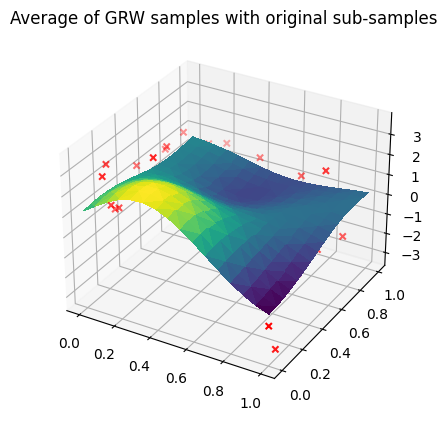

In [17]:
grw_samples_avg = np.mean(grw_samples, axis=0)
plot_result(grw_samples_avg, v, x, y, x[idx], y[idx], title="Average of GRW samples with original sub-samples")

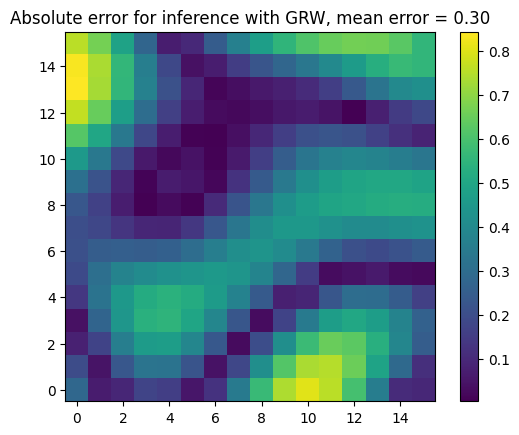

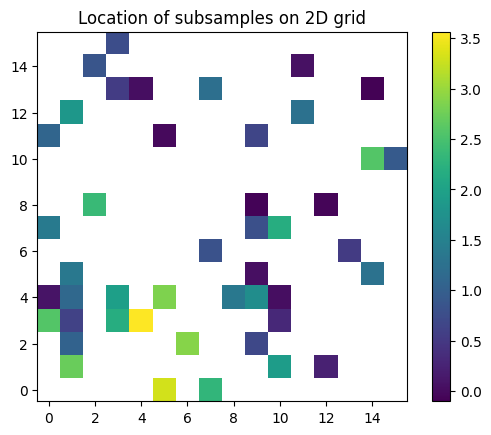

In [18]:
grw_absolute_error = np.abs(grw_samples_avg - u)
grw_mean_error = np.mean(grw_absolute_error)
plot_2D(grw_absolute_error, xi, yi, title="Absolute error for inference with GRW, mean error = "+str(grw_mean_error)[:4], countsMin=True)
plot_2D(v, xi[idx], yi[idx], title="Location of subsamples on 2D grid")

In [19]:
### Part (b) - pCN
u0 = Kc @  np.random.randn(N, )
pcn_samples, pcn_acceptance = pcn(log_likelihood, u0, v, K, G, n, beta)

100%|██████████| 10000/10000 [00:03<00:00, 3313.46it/s]


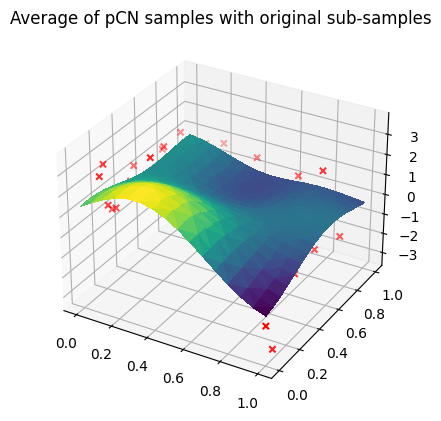

In [20]:
pcn_samples_avg = np.mean(pcn_samples, axis=0)
plot_result(pcn_samples_avg, v, x, y, x[idx], y[idx], title="Average of pCN samples with original sub-samples")

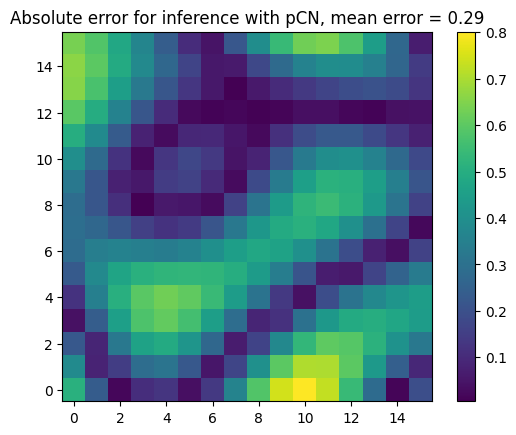

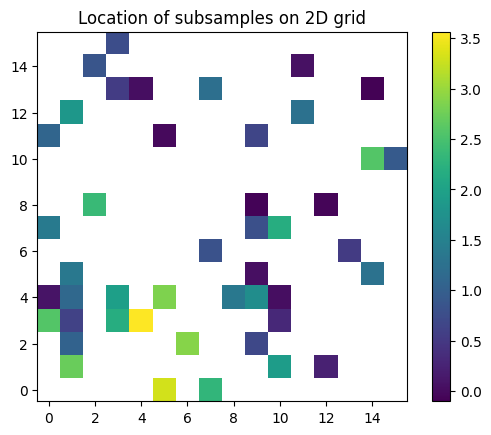

In [40]:
pcn_absolute_error = np.abs(pcn_samples_avg - u)
pcn_mean_error = np.mean(pcn_absolute_error)
plot_2D(pcn_absolute_error, xi, yi, title="Absolute error for inference with pCN, mean error = "+str(pcn_mean_error)[:4], countsMin=True)
plot_2D(v, xi[idx], yi[idx], title="Location of subsamples on 2D grid")

In [45]:
### Part (c)

t = probit(v) # Probit transform of data
K = GaussianKernel(coords, 0.3)
probit_samples, probit_acceptance = pcn(log_probit_likelihood, u0, t, K, G, n, beta)

100%|██████████| 10000/10000 [00:03<00:00, 3110.86it/s]


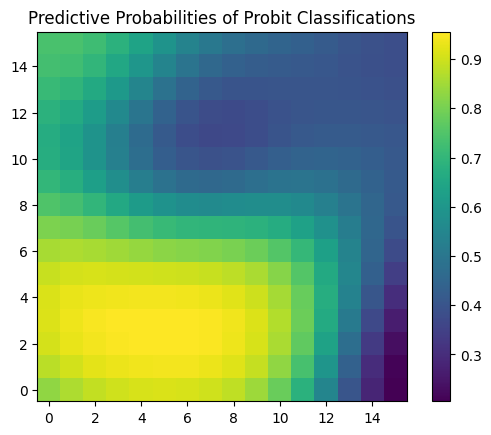

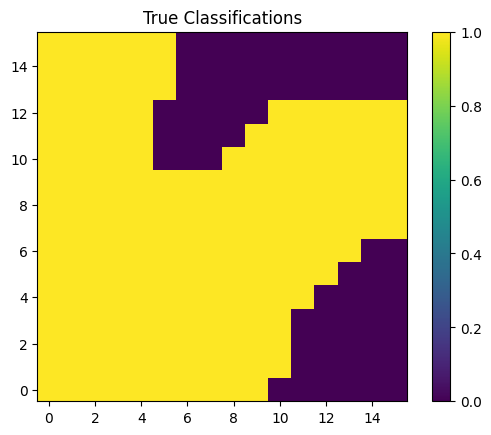

In [46]:
t_dist = predict_t(probit_samples)
t_true = np.where(probit(u) > 0, 1, 0)
plot_2D(t_dist, xi, yi, countsMin=True, title="Predictive Probabilities of Probit Classifications")
plot_2D(t_true, xi, yi, countsMin=True, title="True Classifications")

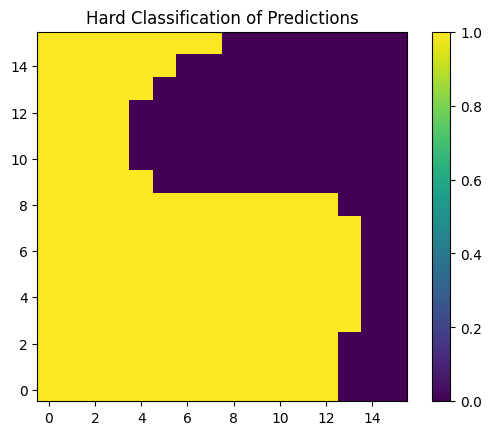

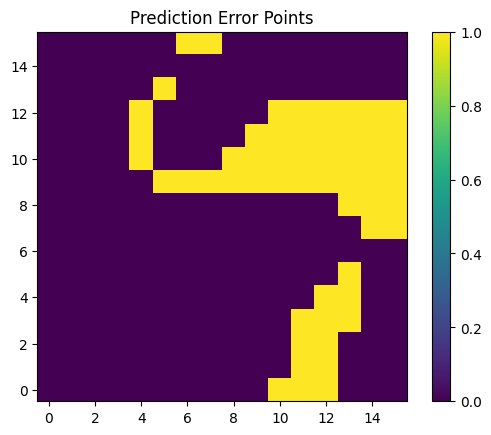

In [47]:
### Part (d)

t_predict = probit(predict_t(probit_samples)-0.5)
prediction_error = np.abs(t_predict - t_true)
plot_2D(t_predict, xi, yi, countsMin=True, title="Hard Classification of Predictions")
plot_2D(prediction_error, xi, yi, countsMin=True, title="Prediction Error Points")

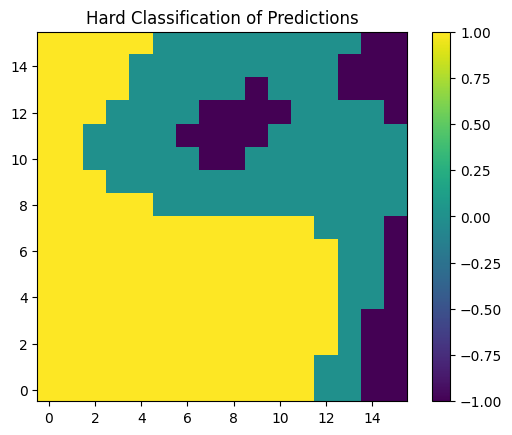

In [49]:
# soft classification
t_soft = np.zeros_like(t_dist)
for i, t in enumerate(t_dist):
	if t < 0.4:
		t_soft[i] = -1
	elif t > 0.6:
		t_soft[i] = 1
plot_2D(t_soft, xi, yi, countsMin=True, title="Soft Classification of Predictions")

In [35]:
# length parameter prediction

num_lengths = 50
a = 10**(3/num_lengths)
l = 0.01
errors_best = 256
l_best = 0.01
errors_list = []
l_list = []
for _ in range(num_lengths):
	print(l)
	K = GaussianKernel(coords, l)
	probit_samples, probit_acceptance = pcn(log_probit_likelihood, u0, t, K, G, n, beta)
	t_predict = probit(predict_t(probit_samples)-0.5) # -0.5 to move boundary to 0.5 from 0
	errors = np.sum(np.abs(t_predict - probit(u)))
	if errors < errors_best:
		errors_best = errors
		l_best = l
	errors_list.append(errors)
	l_list.append(l)
	l *= a

  2%|▏         | 220/10000 [00:00<00:04, 2187.97it/s]

0.01


  3%|▎         | 285/10000 [00:00<00:03, 2822.21it/s]

0.011481536214968828


  3%|▎         | 343/10000 [00:00<00:02, 3396.07it/s]

0.013182567385564073


  3%|▎         | 284/10000 [00:00<00:03, 2821.66it/s]

0.015135612484362085


  7%|▋         | 691/10000 [00:00<00:02, 3466.78it/s]

0.01737800828749376


  3%|▎         | 347/10000 [00:00<00:02, 3437.36it/s]

0.019952623149688802


  3%|▎         | 299/10000 [00:00<00:03, 2960.37it/s]

0.022908676527677738


  3%|▎         | 263/10000 [00:00<00:03, 2609.94it/s]

0.02630267991895383


  3%|▎         | 332/10000 [00:00<00:02, 3287.12it/s]

0.030199517204020174


  3%|▎         | 305/10000 [00:00<00:03, 3021.47it/s]

0.03467368504525318


  3%|▎         | 307/10000 [00:00<00:03, 3046.61it/s]

0.03981071705534975


  3%|▎         | 333/10000 [00:00<00:02, 3297.10it/s]

0.045708818961487534


  3%|▎         | 338/10000 [00:00<00:02, 3346.57it/s]

0.0524807460249773


  3%|▎         | 311/10000 [00:00<00:03, 3079.26it/s]

0.06025595860743582


  3%|▎         | 299/10000 [00:00<00:03, 2989.97it/s]

0.06918309709189371


  3%|▎         | 303/10000 [00:00<00:03, 3009.64it/s]

0.07943282347242824


  3%|▎         | 332/10000 [00:00<00:02, 3320.00it/s]

0.09120108393559108


  3%|▎         | 336/10000 [00:00<00:02, 3326.71it/s]

0.10471285480509009


  3%|▎         | 260/10000 [00:00<00:03, 2574.27it/s]

0.12022644346174145


  3%|▎         | 302/10000 [00:00<00:03, 3001.82it/s]

0.1380384264602887


  3%|▎         | 330/10000 [00:00<00:02, 3267.33it/s]

0.1584893192461116


  3%|▎         | 322/10000 [00:00<00:03, 3219.99it/s]

0.18197008586099864


  7%|▋         | 678/10000 [00:00<00:02, 3374.32it/s]

0.2089296130854043


  3%|▎         | 294/10000 [00:00<00:03, 2910.98it/s]

0.23988329190194949


  3%|▎         | 336/10000 [00:00<00:02, 3359.99it/s]

0.2754228703338172


  3%|▎         | 306/10000 [00:00<00:03, 3055.34it/s]

0.31622776601683855


  2%|▏         | 193/10000 [00:00<00:05, 1910.90it/s]

0.3630780547701021


  6%|▌         | 575/10000 [00:00<00:03, 2878.14it/s]

0.41686938347033625


  3%|▎         | 278/10000 [00:00<00:03, 2778.60it/s]

0.47863009232263937


  3%|▎         | 288/10000 [00:00<00:03, 2851.50it/s]

0.5495408738576257


  2%|▏         | 226/10000 [00:00<00:04, 2237.70it/s]

0.6309573444801947


  2%|▏         | 247/10000 [00:00<00:03, 2469.92it/s]

0.7244359600749918


  2%|▏         | 198/10000 [00:00<00:04, 1979.93it/s]

0.8317637711026731


  3%|▎         | 305/10000 [00:00<00:03, 3019.78it/s]

0.9549925860214384


  6%|▌         | 561/10000 [00:00<00:03, 2802.35it/s]

1.096478196143188


  0%|          | 0/10000 [00:00<?, ?it/s]

1.2589254117941706


  2%|▏         | 237/10000 [00:00<00:04, 2346.58it/s]

1.4454397707459314


  3%|▎         | 261/10000 [00:00<00:03, 2609.98it/s]

1.6595869074375653


  5%|▍         | 483/10000 [00:00<00:03, 2418.31it/s]

1.9054607179632528


  5%|▍         | 470/10000 [00:00<00:04, 2343.91it/s]

2.187761623949559


  3%|▎         | 252/10000 [00:00<00:03, 2511.37it/s]

2.5118864315095877


  2%|▎         | 250/10000 [00:00<00:03, 2475.92it/s]

2.884031503126615


  2%|▏         | 230/10000 [00:00<00:04, 2277.33it/s]

3.3113112148259214


  2%|▏         | 213/10000 [00:00<00:04, 2109.01it/s]

3.8018939632056243


  2%|▏         | 217/10000 [00:00<00:04, 2148.50it/s]

4.365158322401674


  2%|▏         | 213/10000 [00:00<00:04, 2129.42it/s]

5.01187233627274


  2%|▏         | 215/10000 [00:00<00:04, 2149.79it/s]

5.754399373371589


  2%|▏         | 225/10000 [00:00<00:04, 2227.78it/s]

6.606934480075983


  2%|▏         | 198/10000 [00:00<00:04, 1979.91it/s]

7.585775750291865


  2%|▏         | 223/10000 [00:00<00:04, 2230.00it/s]

8.709635899560839


100%|██████████| 10000/10000 [00:04<00:00, 2258.57it/s]


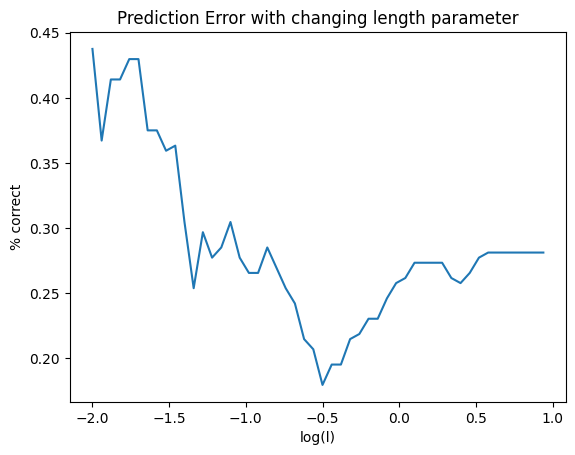

In [37]:
fig, ax = plt.subplots()
ax.plot(np.log10(l_list), np.array(errors_list)/256)
ax.set_xlabel("log(l)")
ax.set_ylabel("% correct")
ax.set_title("Prediction Error with changing length parameter")
plt.show()